## The Standard Black-Scholes Equation
$$\begin{cases} \frac{\partial V}{\partial t} + rS \frac{\partial V}{\partial S} + \frac{1}{2} \sigma^2 S^2 \frac{\partial^2 V}{\partial S^2}  = rV \\ {Initial+Boundary Conditions}  \end{cases}$$


* V: Asset value
* S: Underlying value
* r: Risk-free (or arbitrage free) interest rate
* σ: Volatility (standard deviation) of price (movement)


* Theta (Θ) is a time-rate term
* Delta (∆) is the convective term
* Gamma (Γ) is the diffusion term


So in risk parameters, the PDE becomes:


$ Θ + rSΔ + \frac{1}{2} \sigma^2 S^2Γ  = rV $

## Boundary Value Problem
### $$\begin{cases} \frac{\partial V}{\partial t} + rS \frac{\partial V}{\partial S} + \frac{1}{2} \sigma^2 S^2 \frac{\partial^2 V}{\partial S^2}  = rV \\ V(0,t) = 0\\ V(S_{max}, t) = S_{max} \\ V(S,0) = ϕ(S) \end{cases}$$


$lim_{S\to\infty}V(S,t) = S-Ke^{-r(T-τ)} ≈ S $

## Part II

In [117]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import figure
from matplotlib import cm
from scipy.stats import norm
import time
from math import log, sqrt, pi, exp, erf, ceil, floor, cos, sin, e


#(B) FTCS, BTCS & Crank-Nicolson schemes

In [118]:
def BS_Call(S, K, r, sigma, tau):
    
    #BS for European Call Option, and Delta

    d1 = (np.log(S / K) + (r + 0.5 * sigma**2 * tau)) / (sigma*np.sqrt(tau))

    d2 = (np.log(S / K) + (r - 0.5 * sigma**2 * tau)) / (sigma*np.sqrt(tau))
    
    return (S * norm.cdf(d1) - K * np.exp(-r * tau) * norm.cdf(d2), norm.cdf(d1)) 

In [119]:
#Setup, European Call for schemes
r = 0.04
vol = 0.3
S1_0 = 100 #ITM, where do these come into the problem
S2_0 = 110 #ATM
S3_0 = 120 #OTM
S_max = 300
K = 110
T = 1
X_max = np.log(S_max)

N = S_max #time steps
M = S_max #stock steps

alpha = 10
d_X = 0.01   #dummy value for now, hence d_S is e
d_S = np.exp(d_X)
d_tau =  d_X/alpha  #Choose d_tau small enough such that stability is guaranteed, take from Q1?

u = np.zeros((N,M))
A_1 = np.zeros((N,M))
A_2 = np.zeros((N,M))
A_3 = np.zeros((N,M))
  
k_1 = np.zeros((1,M))
# Changed:
# k_1[0,-1] = S_max
k_1[0,-1] = S_max * ((r-0.5*vol**2)+vol**2/d_X)

k_2 = np.zeros((1,M))
k_2[0,-1] = 2/d_X * S_max
k_3 = np.zeros((1,M))
k_3 = d_tau * (r-0.5*vol**2 + vol**2/d_X)*k_1

delta = np.zeros((1,M))
gamma = np.zeros((1,M))
theta = np.zeros((1,M))
a = np.zeros((1,M))

In [120]:
def initialize_grid(time_length, stock_length, boundary_value):
    
    # Initialize solution: the grid of u(j, i). This is the option price
    u = np.empty((stock_length, time_length)) 

    # Initial condition everywhere inside the grid
    u_initial = 0.0

    # Boundary conditions 
    u_right = S_max
    u_left = 0.0

    # Set the initial condition
    u.fill(u_initial)

    # Set the boundary conditions
    u[:, -1] = u_right
    u[:,0] = u_left
    
    for i in range(stock_length): #Choose the initial value which due to the substittution is the terminal value?
      u[0,i] = max(i-K, 0)

    #print("\nInitial 2-D grid in spatial dimension for time snapshot t=0 is listed below\n")
    #print(u[0,:])
    return u

In [121]:
#Test starting-grid for Option price. 
print(initialize_grid(N, M, S_max)) 

[[  0.   0.   0. ... 187. 188. 189.]
 [  0.   0.   0. ...   0.   0. 300.]
 [  0.   0.   0. ...   0.   0. 300.]
 ...
 [  0.   0.   0. ...   0.   0. 300.]
 [  0.   0.   0. ...   0.   0. 300.]
 [  0.   0.   0. ...   0.   0. 300.]]


In [122]:
#Define matrices for finite differences

def FD_A():
  for j in range(0, N-1, 1):
    A_1[j+1,j] = -1
    A_1[j,j+1] = 1
    A_2[j+1,j] = 1
    A_2[j,j+1] = 1
    A_2[j,j] = -2
    A_2[-1,-1] = -2
    A_3[j,j] =  1 - d_tau*vol**2/(d_X**2) -r*d_tau 
    A_3[0,0] = 1-r*d_tau
    A_3[j, j+1] = 0.5*d_tau*(vol**2/d_X**2 + (r-0.5*vol**2)/d_X) 
    A_3[j+1,j] = A_3[j, j+1] 
    A_3[0,1] = 0
    A_3[1,0] = (d_tau * vol**2)/d_X**2
  return (A_1, A_2, A_3)

In [123]:
def FTCS(u):
  A_1 = FD_A()[0]
  #A_2 = FD_A()[1]
  #A_3 = FD_A()[2]

  for j in range(0, N-1, 1):   #time, for each time point consecutively, we fill space. Do we need d_tau here?
    for i in range(1, M-1, 1):   #space, runs from 1 to M-1
      u[(j + 1), i] = u[j,i] + (r-0.5*vol**2)*d_tau/(2*d_X) * (u[j, i+1]-u[j,i-1]) + (0.5*vol**2) * d_tau/(d_X**2)*(u[j,i+1]-2*u[j,i]+u[j,i-1]) - r*d_tau*u[j,i] 
      delta[0,i] = (1/(2*d_X) * np.dot(A_1[:,i], u[:,i]) + k_1[0,i])/i
      #gamma[0,i] =  1/(d_X**2) * np.dot(A_2[:,i], u[:,i]) + k_2[0,i]
      #theta[0,i] = (r-0.5*vol**2)*delta[0,i] + 0.5*vol**2 *gamma[0,i] - r * u[j,i] 
      #Reference heat equation: u[k + 1, i, j] = gamma * (u[k][i+1][j] + u[k][i-1][j] + u[k][i][j+1] + u[k][i][j-1] - 4*u[k][i][j]) + u[k][i][j]
  return(u, delta)   #This returns V

In [124]:
V = FTCS(initialize_grid(N,M,S_max))[0][:200,:200] 
delta = FTCS(initialize_grid(N,M,S_max))[1][:,:200] #One delta for each point in space. make sure this is calculated right

In [125]:
#Test FTCS, so far everything up to (without) the Greeks works above
#print(V[-1,:])
#print(S.shape, delta) #the bottom boundary is not yet correct, and the right boundary for S is 1 instead of 0?

In [126]:
#Crank Nicolson, to do
def Crank_Nicolson(u):
  A_1 = FD_A()[0]
  #A_2 = FD_A()[1]
  #A_3 = FD_A()[2]

  for j in range(0, N-1, 1):   #time, for each time point consecutively, we fill space. Do we need d_tau here?
    for i in range(1, M-1, 1):   #space, runs from 1 to M-1
      #u[j + 1, i] = (1-r*d_tau) *(u[j,i] + (r-0.5*vol**2)*d_tau/(4*d_X) * (u[j, i+1]-u[j,i-1]+u[j+1, i+1] - u[j+1, i-1]) + (0.25*vol**2) * d_tau/(d_X**2)*(u[j,i+1]-2*u[j,i]+u[j,i-1]+u[j+1, i+1]-2*u[j+1, i]+u[j+1, i-1]) - r*d_tau*(u[j,i]))
      u[j + 1, i] = u[j,i] + (r-0.5*vol**2)*d_tau/(4*d_X) * (u[j, i+1]-u[j,i-1]+u[j+1, i+1] - u[j+1, i-1]) + (0.25*vol**2) * d_tau/(d_X**2)*(u[j,i+1]-2*u[j,i]+u[j,i-1]+u[j+1, i+1]-2*u[j+1, i]+u[j+1, i-1]) - r*d_tau*(u[j,i]-u[j+1, i])  #todo
      #delta[0,i] = 1/(2*d_X) * np.dot(A_1[:,i], u[:,i]) + k_1[0,i] #to do
      #gamma[0,i] =  1/(d_X**2) * np.dot(A_2[:,i], u[:,i]) + k_2[0,i]
      #theta[0,i] = (r-0.5*vol**2)*delta[0,i] + 0.5*vol**2 *gamma[0,i] - r * u[j,i] 
      #Reference heat equation: u[k + 1, i, j] = gamma * (u[k][i+1][j] + u[k][i-1][j] + u[k][i][j+1] + u[k][i][j-1] - 4*u[k][i][j]) + u[k][i][j]
  return(u, delta)   #This returns V

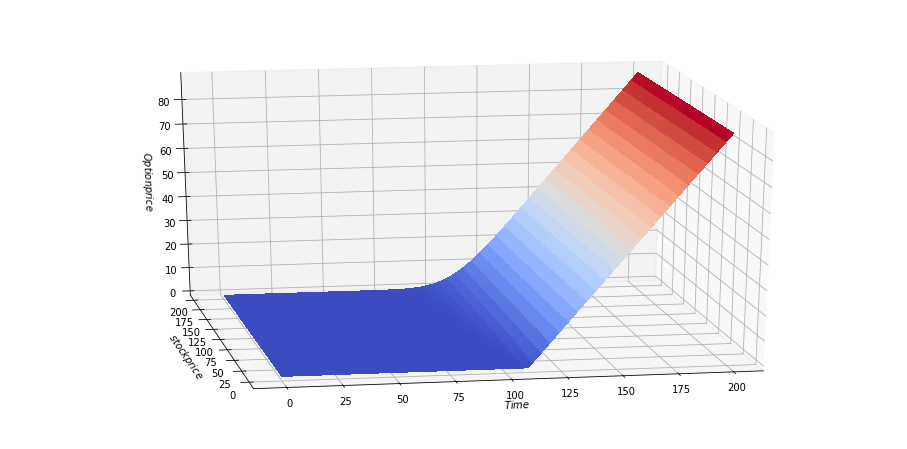

In [127]:
#FTCS 3DGraph
fig = plt.figure(figsize=(16, 8))
ax = fig.gca(projection='3d')

# Make data.
time_grid = np.arange(0, 200, 1)
space_grid = np.arange(0, 200, 1)
time_grid, space_grid = np.meshgrid(time_grid, space_grid)

# Plot the surface.
surf = ax.plot_surface(time_grid,space_grid, V, cmap=cm.coolwarm, linewidth=0, antialiased=False)

ax.set_xlabel('$Time$')
ax.set_ylabel('$stock price$')
ax.set_zlabel(r'$Option price$')
ax.view_init(20, 260)

In [128]:
#Check with BS explicit solution 
test = [S1_0, S2_0, S3_0]
BS_test = []
BS_delta_test = [0]

for i in range(3):
  BS_test = BS_test + [BS_Call(test[i], K, r, vol, 1)[0]] 

for j in np.arange(1, S_max):
  BS_delta_test = BS_delta_test +[ BS_Call(j, K, r, vol, 1)[1]]

print("BS test: ", BS_test)

BS test:  [9.625357828843697, 15.128591111967928, 21.788808338829327]


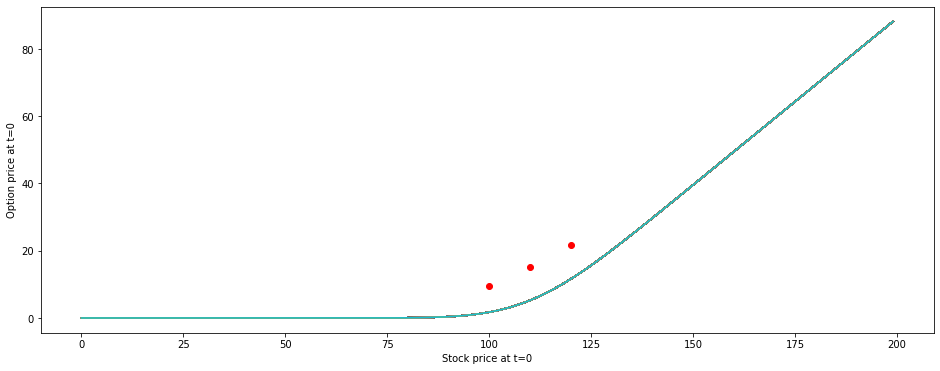

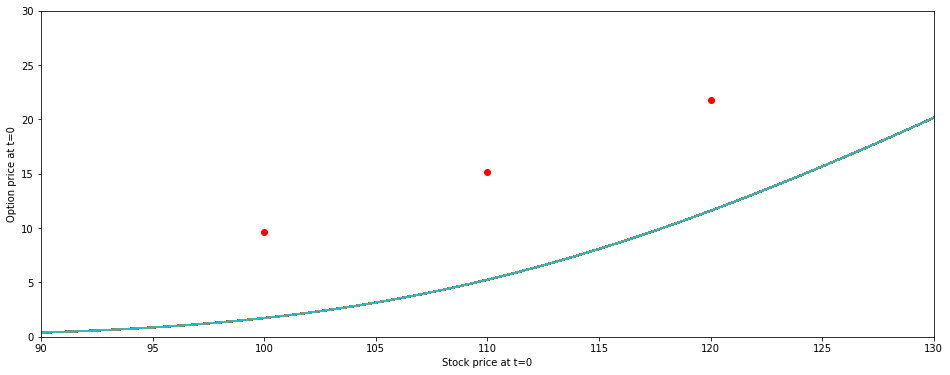

In [129]:
plt.figure(figsize=(16, 6))
plt.plot(space_grid, V[-1,:])
plt.plot(test, BS_test, "ro") #BS test, our estimate is too low
#plt.plot(space_grid, V[0,:])   #This is the initial option price
plt.xlabel("Stock price at t=0")
plt.ylabel("Option price at t=0")
#plt.xlim([0, 200])
#plt.ylim([0, 100])
plt.show()

plt.figure(figsize=(16, 6))
plt.plot(space_grid, V[-1,:])
plt.plot(test, BS_test, "ro") #BS test, our estimate is too low
plt.xlim([90, 130])
plt.ylim([0, 30])
plt.xlabel("Stock price at t=0")
plt.ylabel("Option price at t=0")
plt.show()

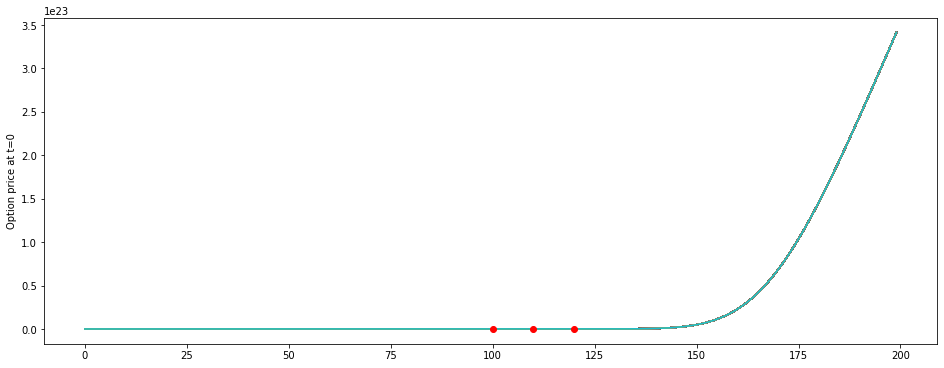

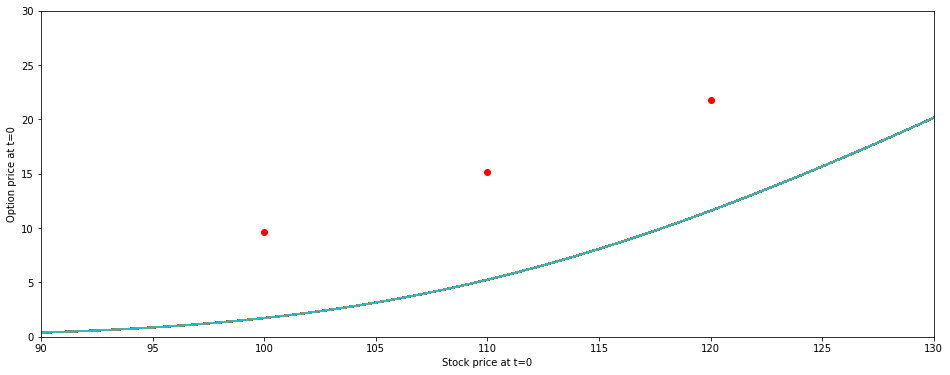

In [130]:
#Test Nicolson
CN = Crank_Nicolson(initialize_grid(N,M,S_max))[0][:200,:200] 
#CN_delta = 1 Crank_Nicolson(initialize_grid(N,M,S_max))[1]

#print(CN[-1,:])

plt.figure(figsize=(16, 6))
plt.plot(space_grid, CN[-1,:])
plt.plot(test, BS_test, "ro") #BS test, our estimate is too low
plt.ylabel("Option price at t=0")
plt.show()

plt.figure(figsize=(16, 6))
plt.plot(space_grid, V[-1,:])
plt.plot(test, BS_test, "ro") #BS test, our estimate is too low
plt.xlim([90, 130])
plt.ylim([0, 30])
plt.xlabel("Stock price at t=0")
plt.ylabel("Option price at t=0")
plt.show()

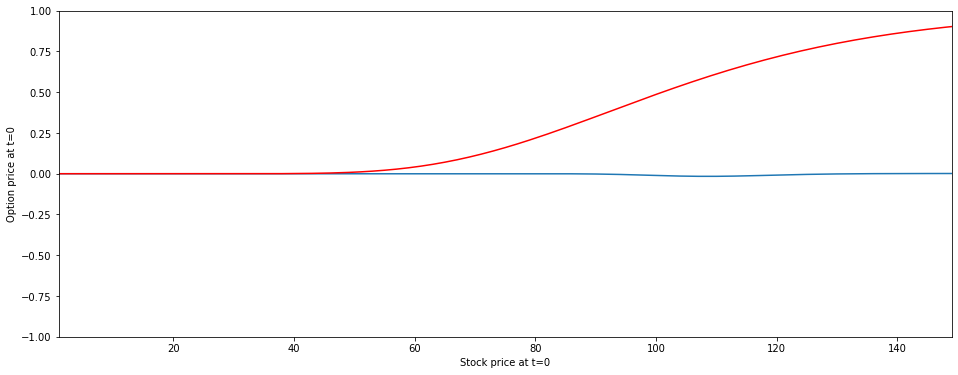

In [131]:
#Delta plot, not there yet
space_grid = np.arange(0, 200, 1)

plt.figure(figsize=(16, 6))
plt.plot(space_grid, np.transpose(delta))
plt.plot(space_grid, np.transpose(BS_delta_test[:200]), "r") #BS test, our estimate is too low
plt.xlim([1, 149])
plt.ylim([-1, 1])
plt.xlabel("Stock price at t=0")
plt.ylabel("Option price at t=0")
plt.show()

In [132]:
#Check delta_tau stability

#Part III

In [133]:
from IPython import get_ipython;   
get_ipython().magic('reset -sf')

#### IIIB. We will be pricing a Europan Call option with the COS Method under the following parameters:
r = 0.04

vol = 30%

$ S_0 = 100$

K = 110

T = 1


In [134]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import time

In [135]:
S0    = 100
K     = 110
r     = 0.04
sigma = 0.3
T     = 1

a = np.log(S0/K) + r - 12*np.sqrt(sigma*sigma*T)
b = np.log(S0/K) + r + 12*np.sqrt(sigma*sigma*T)

In [136]:
def Black_Scholes_Call(S, K, r, sigma, tau):
    """ 
    Black Scholes Model for European Call
    """
    d1 = (np.log(S / K) + (r + ((sigma**2)/2.)*tau)) / (sigma*np.sqrt(tau))
    d2 = d1 - sigma*np.sqrt(tau)
    V  = S * norm.cdf(d1) - np.exp(-r*tau) * K * norm.cdf(d2)
    
    return V

In [137]:
def xk(a, b, c, d, k):
    ''' Equation 22 '''
    ba      = b-a
    kp_ba   = k * np.pi/ba
    kpda_ba = (k*np.pi) * ((d-a)/ba)
    kpca_ba = (k*np.pi) * ((c-a)/ba)

    return (1/(1+np.power(kp_ba,2))) * ( np.cos(kpda_ba)*np.exp(d) -  np.cos(kpca_ba)*np.exp(c) +
                kp_ba*np.sin(kpda_ba)*np.exp(d) - kp_ba*np.sin(kpca_ba)*np.exp(c) )

def psik(a, b, c, d, k):
    ''' Equation 23 '''
    ba    = b-a
    kp_ba = k * np.pi/ba

    if k == 0:
        return d -c
    else: 
        return (1/kp_ba) * (np.sin(kp_ba * (d-a)) - np.sin(kp_ba * (c-a)))

def phi(u, r, sigma, T):
    ''' Assigment 3. GBM '''
    phi_gbm = np.exp(1j * u*T * (r - 0.5 * np.power(sigma,2))  - 0.5 * np.power(sigma,2) * T * np.power(u,2))
    return phi_gbm

def Gk(a,b,k):
    ''' Equation 24 '''
    ba = b-a
    return (K*2/ba) *  (xk(a, b, 0, b, k) - psik(a, b, 0, b, k))

def Fk(u,a,b,k, x):
    ''' Equation 9 '''
    kpxa_ba = np.pi * k *(x-a)/(b-a)
    return np.real(phi(u, r, sigma, T) * (np.exp(1j * kpxa_ba)))

In [138]:
def COS_Method(S0, K, N0):
    ''' Equation 19 '''
    
    sums = np.zeros(N0)
    x  = np.log(S0/K)
    
    for i in range(N0):
        u = i * np.pi/(b-a)
        G_Step = Gk(a,b,i)
        F_step = Fk(u,a,b,i, x)

        if i == 0:
            F_step = F_step * 0.5

        sums[i]=(G_Step*F_step)

    return np.sum(sums) * np.exp(-r * T)

In [139]:
lists_place = {}
S_sums      = []
BS_Values   = []
N_Values    = [32, 64, 96, 128, 160, 192]
S_Values    = [100, 110, 120]

for index in S_Values:
    lists_place['list_%s' % index] = []
    x = []
    bs_index = Black_Scholes_Call(index, K, r, sigma, T)
    for coeff in N_Values:

        begin = time.time()
        end = time.time() - begin
        cos_index = COS_Method(index, 110, coeff)  
        
        x.append([cos_index, abs(cos_index - bs_index), end])

    lists_place['list_%s' %index] = x
        

S1 = np.linspace(30, 200, 60)

for i in S1:
    S_sums.append(COS_Method(i, 110, 64))
    BS_Values.append(Black_Scholes_Call(i, K, r, sigma, T))

In [140]:
S100 = lists_place['list_100']
S110 = lists_place['list_110']
S120 = lists_place['list_120']

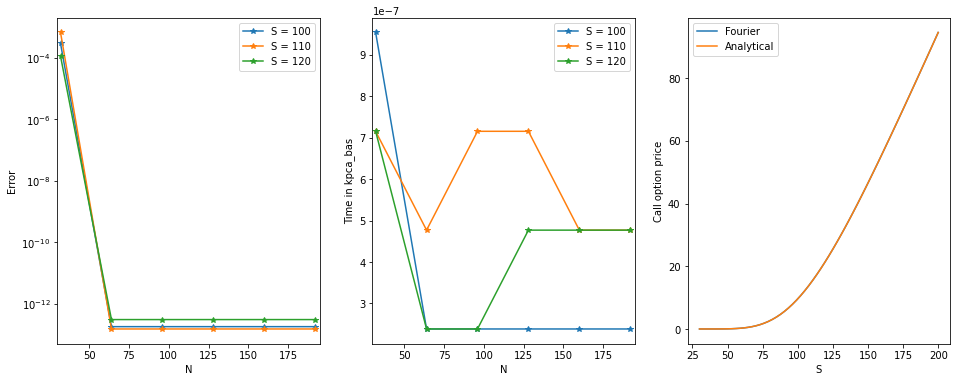

In [141]:
fig, axs = plt.subplots(figsize = (16,6), ncols=3, nrows=1)

axs[0].plot(N_Values, np.array(S100).T[1], label = 'S = 100', marker = '*')
axs[0].plot(N_Values, np.array(S110).T[1], label = 'S = 110', marker = '*')
axs[0].plot(N_Values, np.array(S120).T[1], label = 'S = 120', marker = '*')
axs[0].set_yscale('log')
axs[0].set_xlabel("N")
axs[0].set_xlim([30, 195])
axs[0].set_ylabel("Error")
axs[0].legend()


axs[1].plot(N_Values, np.array(S100).T[2], label = 'S = 100', marker = '*')
axs[1].plot(N_Values, np.array(S110).T[2], label = 'S = 110', marker = '*')
axs[1].plot(N_Values, np.array(S120).T[2], label = 'S = 120', marker = '*')
axs[1].set_xlabel("N")
axs[1].set_xlim([30, 195])
axs[1].set_ylabel("Time in kpca_bas")
axs[1].legend()


axs[2].plot(S1, S_sums, label = 'Fourier')
axs[2].plot(S1, BS_Values, label = 'Analytical')
axs[2].set_ylabel('Call option price')
axs[2].set_xlabel('S')

plt.legend()
plt.show()